# **Atividade 04 - Visão Computacional e Percepção** 

\\

---

**Alunos:**
- Glenda Proença Train
- Jhoser Alaff dos Santos Matheus

\\

---
**Especificação:**

* Exemplo muito tradicional para classificador no site:
  * https://archive.ics.uci.edu/ml/datasets/iris

* Temos um dataset muito conhecido que contém dados de comprimento e largura das sépalas e pétalas de 3 categorias de flores.
* A ideia é vc fazer experimentos de classificação.
* Inicie calculando:
  * Média
  * Desvio
  * Moda de cada variável, em geral e por categoria, bem como a frequência de cada categoria
* Depois analise relação entre comprimento e largura da sépala para cada categoria. 
* Analise como estão distribuídas as categorias nestas 4 dimensões (comprimento e largura da sépala e pétala)
* Leia sobre Principal Component Analysis e veja se consegue algum resultado interessante neste dataset
* Divida o dataset em 80% para treinamento e 20% para teste
* Tente separar as classes com K-NN, analise resultados.
* Entregue relatório sucinto
* Pode ser feito em duplas ou trios.

\\

* **Data de Entrega:** 17/05 (quarta)

\\

---

#### Importações

In [ ]:
%matplotlib inline

# Bibliotecas básicas
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import cycle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# Bibliotecas de pré-processamento
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Biblioteca do modelo
from sklearn.neighbors import KNeighborsClassifier

# Biblioteca da métricas
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#### Leitura dos Dados

In [ ]:
# Função que lê os dados e armazena ele em um DataFrame
def read_data():

  # Define o nome do arquivo que será baixado
  csv_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

  # Define o nome das colunas da planilha baixada
  col_names = ['Sepal_Length','Sepal_Width','Petal_Length','Petal_Width','Class']

  # Lê os dados
  iris =  pd.read_csv(csv_url, names = col_names)

  # Imprime algumas informações
  print("Tamanho do Conjunto de Dados: {}\n".format(len(iris)))
  print("Alguns dados:")
  print(iris.head())
  print("\nTipos dos dados:")
  print(iris.dtypes)

  return(iris)

## Análise dos Dados

#### Cálculo das Métricas Gerais e por Classe

In [ ]:
## Geral:
# Função que calcula as métricas gerais por característica (média, desvio padrão e moda)
def get_general_stats(iris):

  # Calcula a média de cada característica
  each_feature_mean = iris[["Sepal_Length", "Sepal_Width", "Petal_Length", "Petal_Width"]].mean()

  # Calcula o desvio padrão de cada característica
  each_feature_std = iris[["Sepal_Length", "Sepal_Width", "Petal_Length", "Petal_Width"]].std()

  # Calcula a moda de cada característica
  each_feature_mode = iris[["Sepal_Length", "Sepal_Width", "Petal_Length", "Petal_Width"]].mode().squeeze()

  # Combina as informações em um DataFrame
  general_data = pd.DataFrame([each_feature_mean, each_feature_std, each_feature_mode])
  general_data.insert(loc=0, column='Metric', value=["mean", "std", "mode"])
  general_data = general_data.reset_index(drop=True)

  return(general_data)
# -------------------------------------------------------------------------------------------------------------------

## Por Classe
# Função que calcula as métricas por classe (média, desvio padrão e moda)
def get_each_class_stats(iris):
  # Calcula a média de cada característica para cada classe
  each_class_mean = iris.groupby(iris["Class"], as_index=False).mean()
  each_class_mean = each_class_mean.rename(columns={'Sepal_Length': 'Sepal_Length_Mean',
                                                    'Sepal_Width': 'Sepal_Width_Mean',
                                                    'Petal_Length': 'Petal_Length_Mean',
                                                    'Petal_Width': 'Petal_Width_Mean'})

  # Calcula o desvio padrão de cada característica para cada classe
  each_class_std = iris.groupby(iris["Class"], as_index=False).std()
  each_class_std = each_class_std.rename(columns={'Sepal_Length': 'Sepal_Length_Std',
                                                    'Sepal_Width': 'Sepal_Width_Std',
                                                    'Petal_Length': 'Petal_Length_Std',
                                                    'Petal_Width': 'Petal_Width_Std'})

  # Calcula a moda de cada característica para cada classe
  class_1_data = iris[iris["Class"] == "Iris-setosa"].mode().dropna()
  class_2_data = iris[iris["Class"] == "Iris-versicolor"].mode().dropna()
  class_3_data = iris[iris["Class"] == "Iris-virginica"].mode().dropna()
  each_class_mode = pd.concat([class_1_data, class_2_data, class_3_data])
  each_class_mode = each_class_mode.rename(columns={'Sepal_Length': 'Sepal_Length_Mode',
                                                    'Sepal_Width': 'Sepal_Width_Mode',
                                                    'Petal_Length': 'Petal_Length_Mode',
                                                    'Petal_Width': 'Petal_Width_Mode'})


  # Combina os dados de todas as métricas em um DataFrame
  data_by_class = pd.merge(each_class_mean, each_class_std, how="outer", on=["Class"])
  data_by_class = pd.merge(data_by_class, each_class_mode, how="outer", on=["Class"])

  return(data_by_class)
# -------------------------------------------------------------------------------------------------------------------

# Função que calcula quantos exemplos existem de cada classe
def get_classes_frequency(iris):
  # Frequência de cada classe
  class_count = iris.groupby(iris["Class"], as_index=False).size()
  class_count = class_count.rename(columns={'size': 'Frequency'})

  return(class_count)
# -------------------------------------------------------------------------------------------------------------------

# Função que plota os boxplots de todas as características de todas as classes
def get_boxplot(iris):
  fig,ax = plt.subplots(nrows = 2, ncols=2, figsize=(8,5))
  row = 0
  col = 0
  for i in range(len(iris.columns) -1):
      if col > 1:
          row += 1
          col = 0
      axes = ax[row,col]
      sns.boxplot(x = iris['Class'], y = iris[iris.columns[i]],ax = axes)
      col += 1
  plt.tight_layout()
  plt.show()
# -------------------------------------------------------------------------------------------------------------------

#### **Main** | Estatísticas do Conjunto de Dados

In [ ]:
iris = read_data()

Tamanho do Conjunto de Dados: 150

Alguns dados:
   Sepal_Length  Sepal_Width  Petal_Length  Petal_Width        Class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

Tipos dos dados:
Sepal_Length    float64
Sepal_Width     float64
Petal_Length    float64
Petal_Width     float64
Class            object
dtype: object


In [ ]:
print("Frequência de Cada Classe:")
class_count = get_classes_frequency(iris)
class_count

Frequência de Cada Classe:


,Class,Frequency
0,Iris-setosa,50
1,Iris-versicolor,50
2,Iris-virginica,50


In [ ]:
print("Resultados Gerais:")
general_data = get_general_stats(iris)
general_data

Resultados Gerais:


,Metric,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width
0,mean,5.843333,3.054000,3.758667,1.198667
1,std,0.828066,0.433594,1.764420,0.763161
2,mode,5.000000,3.000000,1.500000,0.200000


In [ ]:
print("Resultados por Classe:")
data_by_class = get_each_class_stats(iris)
data_by_class

Resultados por Classe:


,Class,Sepal_Length_Mean,Sepal_Width_Mean,Petal_Length_Mean,Petal_Width_Mean,Sepal_Length_Std,Sepal_Width_Std,Petal_Length_Std,Petal_Width_Std,Sepal_Length_Mode,Sepal_Width_Mode,Petal_Length_Mode,Petal_Width_Mode
0,Iris-setosa,5.006,3.418,1.464,0.244,0.352490,0.381024,0.173511,0.107210,5.0,3.4,1.5,0.2
1,Iris-versicolor,5.936,2.770,4.260,1.326,0.516171,0.313798,0.469911,0.197753,5.5,3.0,4.5,1.3
2,Iris-virginica,6.588,2.974,5.552,2.026,0.635880,0.322497,0.551895,0.274650,6.3,3.0,5.1,1.8


In [ ]:
df = data_by_class.copy()
df['SL_Mean/SW_Mean'] = (df["Sepal_Length_Mean"] / df["Sepal_Width_Mean"])
df['SL_Std/SW_Std'] = (df["Sepal_Length_Std"] / df["Sepal_Width_Std"])
df['SL_Mode/SW_Mode'] = (df["Sepal_Length_Mode"] / df["Sepal_Width_Mode"])
df[['Class', 'SL_Mean/SW_Mean', 'SL_Std/SW_Std', 'SL_Mode/SW_Mode']]

,Class,SL_Mean/SW_Mean,SL_Std/SW_Std,SL_Mode/SW_Mode
0,Iris-setosa,1.464599,0.925111,1.470588
1,Iris-versicolor,2.142960,1.644914,1.833333
2,Iris-virginica,2.215198,1.971740,2.100000


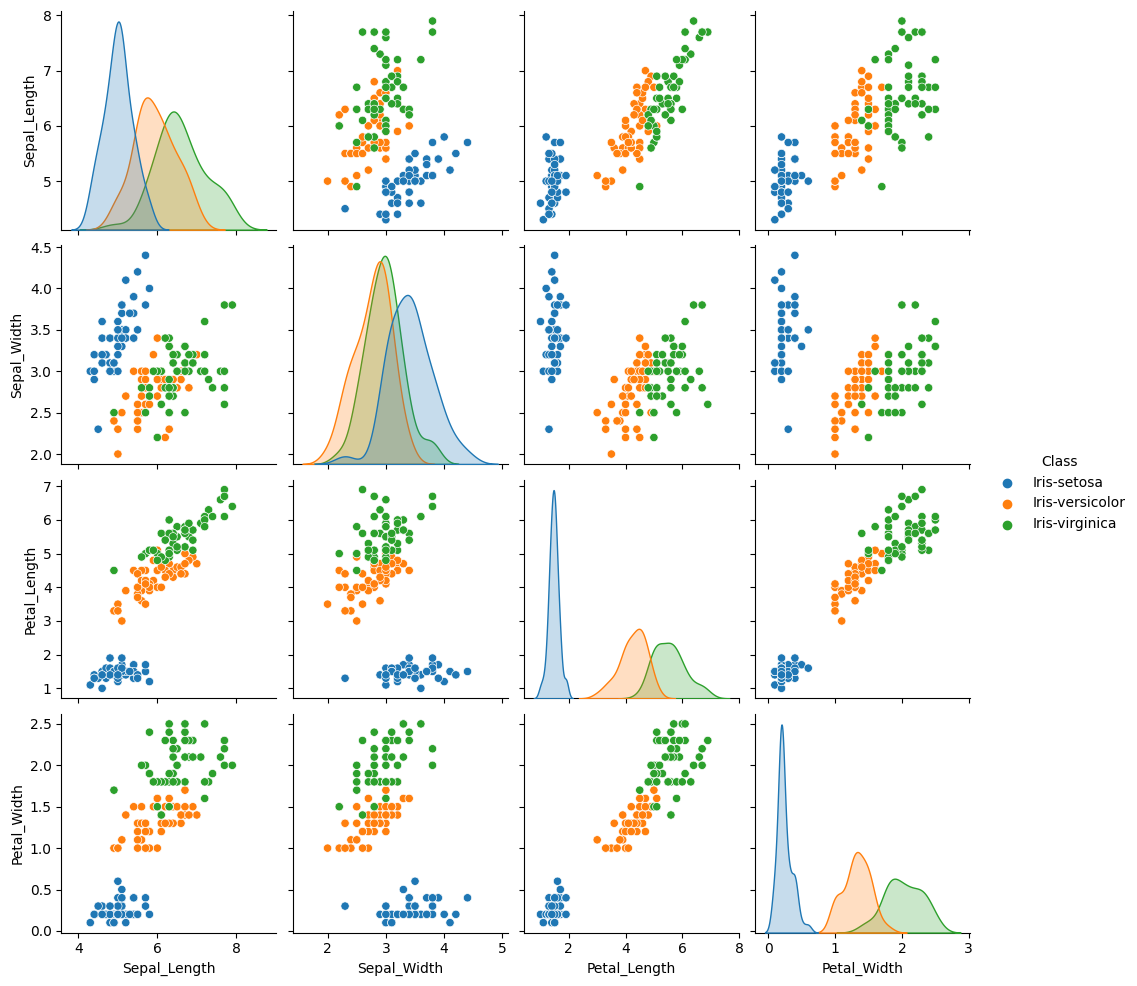

In [ ]:
p=sns.pairplot(iris, hue='Class')
p

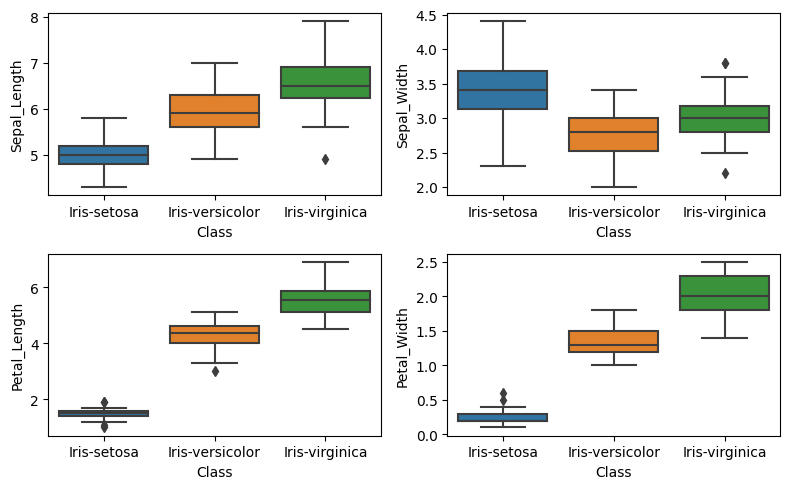

In [ ]:
get_boxplot(iris)

## Classificação

#### Divisão do Conjunto de Dados em Conjunto de Treino e Conjunto de Teste

In [ ]:
# Função que divide o conjunto de dados em dados de conjunto de treinamento e teste
def split_dataset(data, test_size, classes):
  
  # Divide os dados em características e rótulos
  X = data[classes]
  y = data["Class"]

  # Divide os dados em conjunto de treino e teste de acordo com a porcentagem "test_size" informada
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

  print("\nConjunto de Dados:")
  print("  - Formato dos dados de treino: {}".format(X_train.shape))
  print("  - Formato dos rótulos de treino: {}".format(y_train.shape))
  print("  - Formato dos dados de teste: {}".format(X_test.shape))
  print("  - Formato dos rótulos de teste: {}".format(y_test.shape))

  train = {
      "data": X_train,
      "labels": y_train
  }

  test = {
      "data": X_test,
      "labels": y_test
  }

  return(train, test)

#### Funções do Modelo KNN

In [ ]:
# -------------------------------------------------------------------------------------------------------------------

# Função que cria e treino o modelo
def build_and_train_model(train, n_neighbors=3):
  print("\nTreinando o modelo KNN considerando a distância entre {} vizinhos...".format(n_neighbors))

  # Cria o modelo
  knn = KNeighborsClassifier(n_neighbors=n_neighbors)

  # Treina
  knn.fit(train["data"], train["labels"])
  return(knn)
# -------------------------------------------------------------------------------------------------------------------

# Função que retorna as previsões do modelo treinado
def get_model_predictions(model, test_data):
  predictions = model.predict(test_data)
  return(predictions)
# -------------------------------------------------------------------------------------------------------------------

# Função que calcula as métricas gerais e por classe das previsões do modelo
def calc_metrics(test_labels, predictions):
  general_metrics = {}
  general_metrics["accuracy"] = accuracy_score(test_labels, predictions)
  general_metrics["precision"] = precision_score(test_labels, predictions, average='macro')
  general_metrics["recall"] = recall_score(test_labels, predictions, average='macro')
  general_metrics["f1_score_"] = f1_score(test_labels, predictions, average='macro')

  # Define as classes do conjunto de teste
  classes = list(set(test_labels))

  # Calcula as métricas por classe
  metrics_by_class = {}
  for class_ in classes:
    metrics_by_class[class_] = {}

    # Define os índices da classe atual
    indexes = test_labels == class_

    # Extrai os rótulos e predições da classe atual
    y_test = test_labels[indexes]
    y_pred = predictions[indexes]

    # Calcula as métricas da classe atual
    metrics_by_class[class_]["accuracy"] = accuracy_score(y_test, y_pred)
    metrics_by_class[class_]["precision"] = precision_score(y_test, y_pred, average='macro')
    metrics_by_class[class_]["recall"] = recall_score(y_test, y_pred, average='macro')
    metrics_by_class[class_]["f1_score_"] = f1_score(y_test, y_pred, average='macro')

  print("\nMétricas Gerais:")
  print("  - Acurácia: {:.4}".format(general_metrics["accuracy"]))
  print("  - Precisão: {:.4}".format(general_metrics["precision"]))
  print("  - Recall: {:.4}".format(general_metrics["recall"]))
  print("  - F1-Score: {:.4}".format(general_metrics["f1_score_"]))

  print("\nMétricas por Classe:")
  for class_ in classes:
    print("  Classe: {}".format(class_))
    print("    - Acurácia: {:.4}".format(metrics_by_class[class_]["accuracy"]))
    print("    - Precisão: {:.4}".format(metrics_by_class[class_]["precision"]))
    print("    - Recall: {:.4}".format(metrics_by_class[class_]["recall"]))
    print("    - F1-Score: {:.4}\n".format(metrics_by_class[class_]["f1_score_"]))

  return(general_metrics, metrics_by_class)
# -------------------------------------------------------------------------------------------------------------------

# Função que plota a curva ROC de cada classe
def plot_roc_curve(train, test, knn):

  # Descobre o nome das classes
  classes = list(set(test["labels"]))

  # Cria um binarizados de classes
  label_binarizer = LabelBinarizer().fit(train["labels"])

  # Transforma os rótulos em onehot encoding
  y_onehot_test = label_binarizer.transform(test["labels"])

  # Descobre os scores da predição
  y_score = knn.fit(train["data"], train["labels"]).predict_proba(test["data"])

  # Cria o plot
  fig, ax = plt.subplots(figsize=(6, 6))

  # Define as cores das curvas
  colors = cycle(["aqua", "darkorange", "cornflowerblue"])

  # Plot a curva de cada classe
  for class_id, color in zip(range(3), colors):
      RocCurveDisplay.from_predictions(
          y_onehot_test[:, class_id],
          y_score[:, class_id],
          name=f"ROC curve for {classes[class_id]}",
          color=color,
          ax=ax,
      )

  plt.axis("square")
  plt.xlabel("Taxa de Falsos Positivos")
  plt.ylabel("Taxa de Verdadeiros Positivos")
  plt.title("Curva ROC (Receiver Operating Characteristic)")
  plt.legend()
  plt.show()
# -------------------------------------------------------------------------------------------------------------------

# Função que calcula e plota a matriz de confusão
def plot_confusion_matrix(test_labels, predictions):

  # Define as classes
  classes = list(set(test_labels))

  # Calcula a matriz de confusão
  cm = confusion_matrix(test_labels, predictions, labels=classes)

  # Plota
  print()
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  disp.plot()
  plt.show()
# -------------------------------------------------------------------------------------------------------------------

#### **Main** | KNN

Tamanho do Conjunto de Dados: 150

Alguns dados:
   Sepal_Length  Sepal_Width  Petal_Length  Petal_Width        Class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

Tipos dos dados:
Sepal_Length    float64
Sepal_Width     float64
Petal_Length    float64
Petal_Width     float64
Class            object
dtype: object

Conjunto de Dados:
  - Formato dos dados de treino: (120, 4)
  - Formato dos rótulos de treino: (120,)
  - Formato dos dados de teste: (30, 4)
  - Formato dos rótulos de teste: (30,)

Treinando o modelo KNN considerando a distância entre 3 vizinhos...

Métricas Gerais:
  - Acurácia: 1.0
  - Precisão: 1.0
  - Recall: 1.0
  - F1-Score: 1.0

Métricas por Classe:
  Classe: Iris-virgini

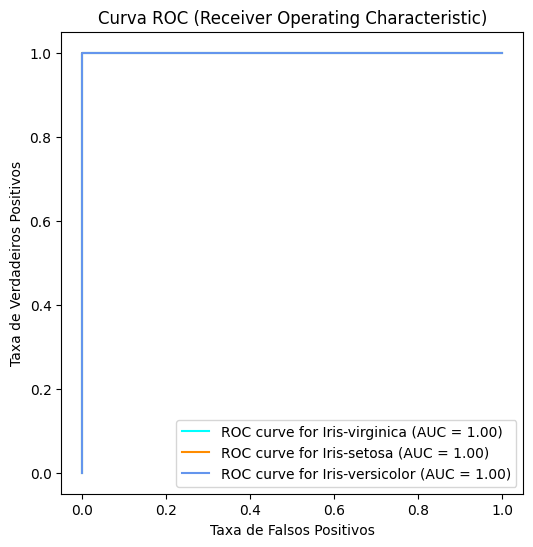

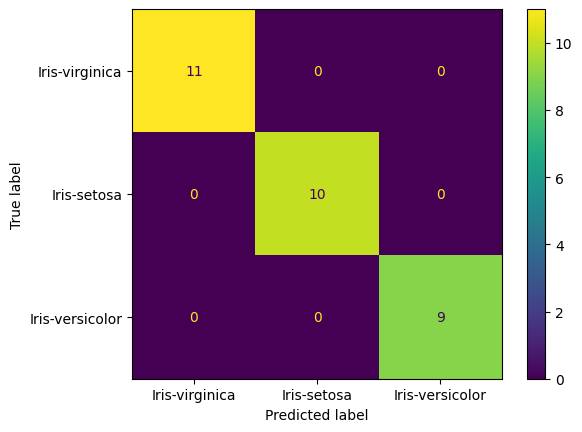

In [ ]:
# Lê os dados
iris = read_data()

# Divide o conjunto de dados em conjunto de treino e teste
train, test = split_dataset(iris, 0.20, ["Sepal_Length", "Sepal_Width", "Petal_Length", "Petal_Width"])

# Constrói e treino o modelo KNN
knn = build_and_train_model(train, n_neighbors=3)

# Extrai as predições do modelo KNN no conjunto de teste
predictions = get_model_predictions(knn, test["data"])

# Calcula as métricas
general_metrics, metrics_by_class = calc_metrics(test["labels"], predictions)

# Plota a curva ROC
plot_roc_curve(train, test, knn)

# Plota a matriz de confusão
plot_confusion_matrix(test["labels"], predictions)

## PCA

### **Redução de Dimensionalidade com PCA** | Visualização

In [ ]:
# -------------------------------------------------------------------------------------------------------------------
# Definições de algumas constantes
PALETTE = sns.color_palette('deep', n_colors=3)
CMAP = ListedColormap(PALETTE.as_hex())
# -------------------------------------------------------------------------------------------------------------------

# Função que plota os dados resultantes da PCA em 2 dimensões
def plot_iris_2d(x, y, classes, title, xlabel="1º Autovetor", ylabel="2º Autovetor"):
    
  # Plota
  plt.scatter(x, y,
      c=classes,
      cmap=CMAP,
      s=70)
  
  # Configurações do plot
  plt.title(title, fontsize=20, y=1.03)
  plt.xlabel(xlabel, fontsize=16)
  plt.ylabel(ylabel, fontsize=16)
# -------------------------------------------------------------------------------------------------------------------

* Visualização 2D

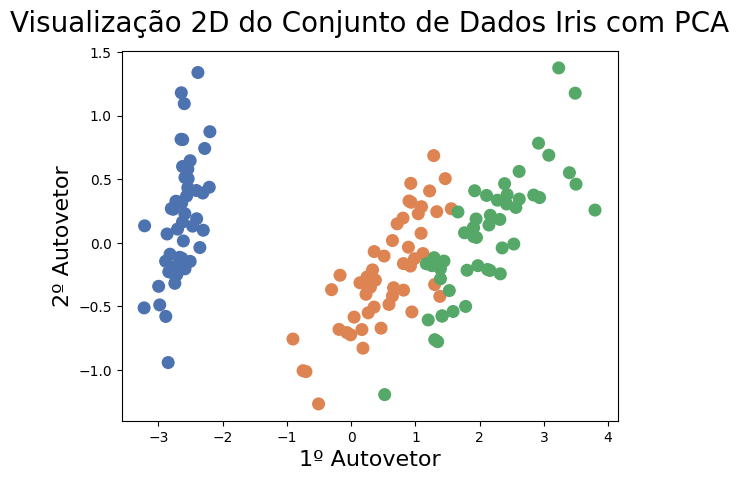

In [ ]:
# Lê o conjunto de dados Iris
dataset = load_iris()

# Define as características e as classes (target)
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
target = 'species'

# Combina as informações em um DataFrame
iris = pd.DataFrame(dataset.data, columns=features)
iris[target] = dataset.target

# Cria a PCA
pca = PCA(n_components=2)

# Executa a PCA
points = pca.fit_transform(iris[features])

# Plota em 2 dimensões
plot_iris_2d(points[:,0], points[:,1], iris['species'], 'Visualização 2D do Conjunto de Dados Iris com PCA')

#### Classificação com PCA


Métricas Gerais:
  - Acurácia: 1.0
  - Precisão: 1.0
  - Recall: 1.0
  - F1-Score: 1.0

Métricas por Classe:
  Classe: 0
    - Acurácia: 1.0
    - Precisão: 1.0
    - Recall: 1.0
    - F1-Score: 1.0

  Classe: 1
    - Acurácia: 1.0
    - Precisão: 1.0
    - Recall: 1.0
    - F1-Score: 1.0

  Classe: 2
    - Acurácia: 1.0
    - Precisão: 1.0
    - Recall: 1.0
    - F1-Score: 1.0



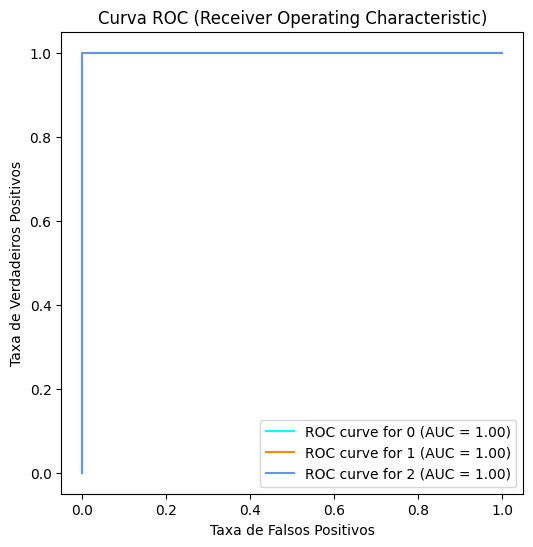

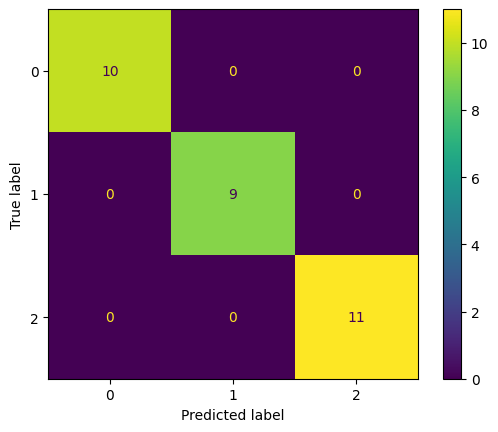

In [ ]:
# Lê o conjunto de dados Iris
dataset = load_iris()

# Define as características e as classes (target)
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
target = 'species'

# Combina as informações em um DataFrame
iris = pd.DataFrame(dataset.data, columns=features)
iris[target] = dataset.target

# Cria a PCA
pca = PCA(n_components=2)

# Executa a PCA
points = pca.fit_transform(iris[features])

# Divide o conjunto de dados em treinamento e teste
X_train_new, X_test_new, y_train, y_test = train_test_split(points, iris[target], test_size = 0.2, random_state=42)

# Cria e treina o classificador K-NN
knn_pca = KNeighborsClassifier(n_neighbors=3)
knn_pca.fit(X_train_new, y_train)

# Extrai as predições do modelo KNN no conjunto de teste
predictions = get_model_predictions(knn_pca, X_test_new)

# Calcula as métricas
general_metrics, metrics_by_class = calc_metrics(y_test, predictions)

# Plota a curva ROC
train_pca = {"data": X_train_new, "labels": y_train}
test_pca = {"data": X_test_new, "labels": y_test}
plot_roc_curve(train_pca, test_pca, knn_pca)

# Plota a matriz de confusão
plot_confusion_matrix(test_pca["labels"], predictions)

* Definição do Número de Componentes

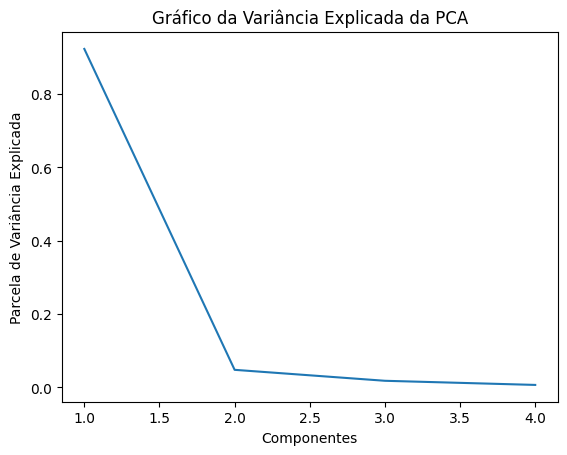


Componente 1 tem 92.26 % de variância
Componente 2 tem 4.813 % de variância
Componente 3 tem 1.826 % de variância
Componente 4 tem 0.699 % de variância


In [ ]:
# Cria uma cópia do conjunto de dados
X_rs = iris.copy()

# Executa para 4 componentes
pca = PCA(n_components=4, whiten=True)

# Aplica no conjunto de dados
pca.fit(X_rs)

# Extrai os valores de variância
explained_variance = pca.explained_variance_ratio_
singular_values = pca.singular_values_

# Cria um x para cada componente
x = np.arange(1,len(explained_variance)+1)

# Plota os resultados
plt.plot(x, explained_variance)

# Adiciona a legenda ao eixo y
plt.ylabel('Parcela de Variância Explicada')
plt.title("Gráfico da Variância Explicada da PCA")
plt.xlabel("Componentes")
plt.show()

# Itera sobre os componentes para imprimir a variância explicada
print()
for i in range(0, 4):
  print("Componente {} tem {:.4} % de variância".format(i+1, explained_variance[i]*100))